# Diário Energético: Projeto Semantix - Breno Dobroski

Cada casa com um medidor inteligente gera milhões de pontos de dados que, à primeira vista, parecem caóticos. Este projeto mergulha nestes dados para encontrar a história por trás dos números: os padrões diários, semanais e anuais que definem a rotina de consumo de uma residência. O objetivo é transformar este "ruído" em insights claros e, por fim, em um modelo de previsão preciso.

O objetivo deste projeto é construir e avaliar um modelo de Machine Learning para prever o consumo de energia. O trabalho será focado em quatro etapas principais:

- Analisar: Investigar os dados para descobrir e visualizar os padrões de consumo (EDA).

- Preparar: Criar novas features (variáveis) de tempo e de lag para dar contexto ao modelo.

- Modelar: Treinar e otimizar dois algoritmos de regressão: Random Forest e XGBoost.

- Avaliar: Medir a performance dos modelos de forma robusta, usando TimeSeriesSplit para garantir uma avaliação honesta e realista.

## Variáveis

Data = Dia de cada medição

Time = Hora de cada medição

Global_Ative_Power = Esta é a energia útil, a que realmente realiza trabalho em casa, pensa nela como a força que acende as lâmpadas, esquenta o chuveiro e etc. É a principal medida do consumo total da casa em um determinado momento, quanto maior este numero, mais coisas estão ligadas e funcionando

Global_Reactive_Power = Está é uma energia um pouco mais técnica. Alguns aparelhos com motores (como geladeiras e ar condicionados) precisam dela para criar campos magnéticos e funcionar. É uma energia de "Suporte"

Voltage = Pense na eletricidade como a água em uma mangueira. A tensão é a pressão dessa água. Ela precisa estar na medida certa (como 110V ou 220V no Brasil) para que os aparelhos funcionem corretamente, sem queimar nem operar com pouca força.

Global_Intensity = Usando a mesma analogia da mangueira: se a tensão é a pressão da água, a intensidade é o fluxo, ou seja, a quantidade de água que está passando pelos fios a cada segundo. Quando você liga um aparelho potente como o chuveiro, o fluxo de eletricidade aumenta drasticamente.

Kitchen_metering = Mede o consumo de energia da cozinha, que inclui principalmente a lava-louças, o forno e o micro-ondas.

Laundry_metering = Mede o consumo da área de serviço, incluindo a máquina de lavar, a secadora de roupas, a geladeira e uma lâmpada.

Air_conditioning_metering = Mede o consumo de dois dos maiores "vilões" da conta de luz: um aquecedor de água elétrico e o ar-condicionado.


In [9]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

In [10]:
df = pd.read_csv("household_power_consumption.txt", delimiter=';', low_memory=False, na_values=['?'])

In [11]:
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.000,239.70,3.8,0.0,0.0,0.0


In [12]:
df.rename(columns={
    'Sub_metering_1': 'Kitchen_metering',
    'Sub_metering_2': 'Laundry_metering',
    'Sub_metering_3': 'Air_conditioning_metering'
}, inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Date                       object 
 1   Time                       object 
 2   Global_active_power        float64
 3   Global_reactive_power      float64
 4   Voltage                    float64
 5   Global_intensity           float64
 6   Kitchen_metering           float64
 7   Laundry_metering           float64
 8   Air_conditioning_metering  float64
dtypes: float64(7), object(2)
memory usage: 142.5+ MB


Aqui analisamos que os dados estão em seus tipos corretos, não temos dados categoricos então não teremos que utilizar o label encoder ou o one hot encoder

In [15]:
df.isnull().sum()

Date                             0
Time                             0
Global_active_power          25979
Global_reactive_power        25979
Voltage                      25979
Global_intensity             25979
Kitchen_metering             25979
Laundry_metering             25979
Air_conditioning_metering    25979
dtype: int64

Podemos ver que temos uma quantidade considerável de dados nulos e faltantes muito provavlmente pelo na_values=['?'] que colocamos quando carregamos o dataset, esse comando serve para considerarmos nulos os dados que tenham '?', vamos agora ver a % de dados nulos em cada coluna

In [17]:
print("Percentual de dados nulos por coluna:")
df.isnull().sum() / len(df) * 100

Percentual de dados nulos por coluna:


Date                         0.000000
Time                         0.000000
Global_active_power          1.251844
Global_reactive_power        1.251844
Voltage                      1.251844
Global_intensity             1.251844
Kitchen_metering             1.251844
Laundry_metering             1.251844
Air_conditioning_metering    1.251844
dtype: float64

Como podemos ver os dados nulos representam 1.25% da nosas base de dados, como é um número muito baixo iremos excluir

In [19]:
df = df.dropna().copy()

In [20]:
df.isnull().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Kitchen_metering             0
Laundry_metering             0
Air_conditioning_metering    0
dtype: int64

In [21]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen_metering,Laundry_metering,Air_conditioning_metering
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [22]:
# Listas vazias para os resultados
continuous = []
categorical = []

# Loop pelas colunas
for c in df.columns[:-1]:
    if df.dtypes[c] == float:
        continuous.append(c)
    else:
        categorical.append(c)

continuous.append("Air_conditioning_metering")

In [23]:
continuous

['Global_active_power',
 'Global_reactive_power',
 'Voltage',
 'Global_intensity',
 'Kitchen_metering',
 'Laundry_metering',
 'Air_conditioning_metering']

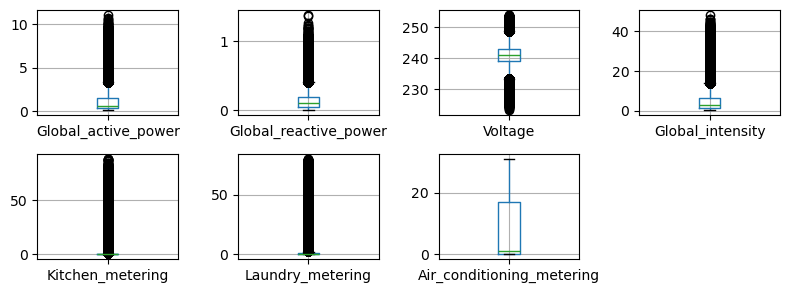

In [24]:
# Tamanho da área de plotagem
fig = plt.figure(figsize = (8,10))

# Loop pelas variáveis contínuas
for i, col in enumerate(continuous):
    plt.subplot(7, 4, i + 1);
    df.boxplot(col);
    plt.tight_layout()

Nos gráficos "Global_active_power", "Global_reactive_power" e "Global_intensity" a caixa que representa 50% dos dados está muito comprimida, perto do valor zero, acima da caixa vemos uma nuvem densa e longa de pontos, que são os outliers. Isso nos diz que a maior parte do tempo (75% ou mais, na verdade), a casa consome uma quantidade de energia muito baixa e cosntante. Os outliers representam os picos de consumo, momentos em que aparelhos de alta potência são ligados.

Nos gráficos "Kitchen_metering" e "Laundry_metering" o padrão é ainda mais extremo. A caixa é praticamente uma linha reta no valor zero. Isso significa que, na grande maioria do tempo, os circuitos específicos medidos por esses sub-medidores estão desligados (consumo zero). Os "outliers" não são bem outliers no sentido clássico; eles são, na verdade, os únicos momentos em que esses circuitos estão em uso

O gráfico "Voltage" é o mais diferente e interessante. A distribuição muito mais simétrica. A caixa mais "alta" e os outliers presentes tanto acima quanto abaixo. Isso é esperado para a tensão de rede elétrica, que deve eprmanecer estável em torno de um valor (neste caso, 240V). A mediana está bem no centro da caixa. Os outliers apresentam pequenas flutuações, quedas ou picos de tensão na rede 

Já o gráfico "Air_conditioning_metering" podemos ver que ele é bem mais constante e estável, a mediana ainda próxima a zero significa que ele está na maior parte do tempo sem utilizar energia. Porém não tem picos como a cozinha e a lavanderia

Como vimos que não são outliers e sim os nossos dados principais do nosso dataset não iremos retirar, iremos seguir agora para a Analise Exploratória

In [30]:
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')

# Passo 3: Definir como índice
df.set_index('datetime', inplace=True)

# Passo 4: Limpar as colunas antigas
df.drop(['Date', 'Time'], axis=1, inplace=True)

---

### Análise Exploratória

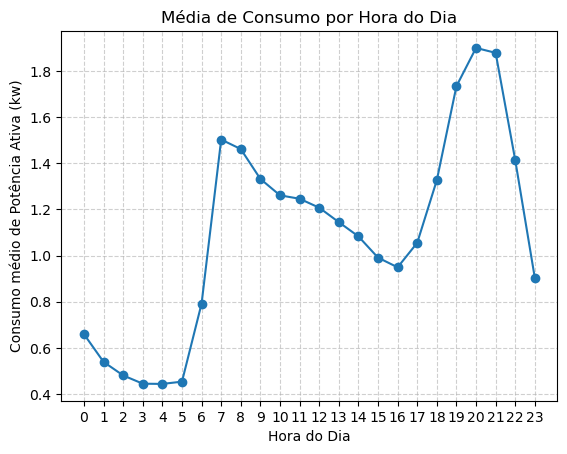

In [33]:
consumo_por_hora = df['Global_active_power'].groupby(df.index.hour).mean()

consumo_por_hora.plot(kind='line', marker='o', linestyle='-')
plt.title("Média de Consumo por Hora do Dia")
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo médio de Potência Ativa (kw)")
plt.xticks(range(0,24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Podemos ver que entre meia-noite e 5h da manhã o consumo é o mais baixo do dia, mas se mantém em um nível estável de aproximadamente 0.45kW. Esse valor representa a energia gasta por aparelhos que nunca desligam.
Das 6h até as 8h o consumo dispara, atingindo um pico acentuado por volta das 7h chegando a 1.5kW, esse é claramente o momento que os moradroes acordam e se preparam para o dia.
A energia volta a cair entre 9h e 16h permanecendo em um patamar moderado por volta de 1.0kW, isso sugere fortemente que a casa fica vazia ou com pouca atividade, muito provavelmente os moradores saem para trabalhar ou estudar.
Por volta das 17h até as 21h temos um novo pico atingindo quase 1.9kW, este é o período de maior atividade na casa, e das 22h até as 23h o consumo cai drasticamente indicando que os moradores estão encerrando suas atividades

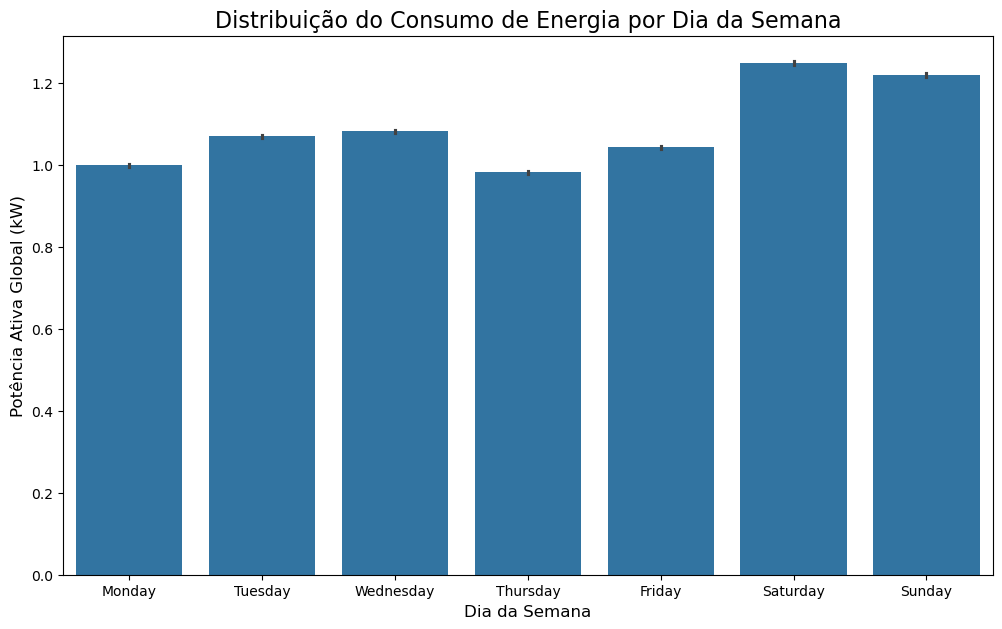

In [35]:
df['Dia_da_Semana'] = df.index.day_name()

ordem_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Cria a figura com um tamanho adequado
plt.figure(figsize=(12, 7))

# Cria o boxplot
sns.barplot(
    data=df,
    x='Dia_da_Semana',
    y='Global_active_power',
    order=ordem_dias,  # Usa a ordem que definimos
)

# Adiciona títulos e rótulos
plt.title('Distribuição do Consumo de Energia por Dia da Semana', fontsize=16)
plt.xlabel('Dia da Semana', fontsize=12)
plt.ylabel('Potência Ativa Global (kW)', fontsize=12)
plt.show()

Podemos perceber que a maior difereça é entre os dias úteis e o fim de semana, isso indica que a atividade doméstica é muito maior durante o fim de semana, pois logicamente os moradores estão em casa o dia inteiro. O sábado é o pico da semana, talvez possa ser o dia da faxina ou de tarefas mais pesadas como uso intenso da máquina de lavar e secadora.

O consumo de segunda a sexta é mais baixo e estável. A queda na quinta é um detalhe interessante, pode ser apenas uma variação estatística ou algum hábito sutil da família (talvez o dia de jantar fora?)

<Axes: title={'center': 'Tendência de Consumo Anual'}, xlabel='datetime', ylabel='Consumo'>

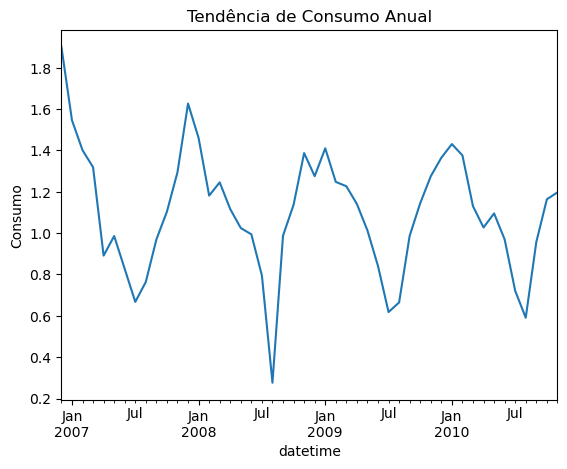

In [37]:
df_mensal = df['Global_active_power'].resample('ME').mean()
plt.title("Tendência de Consumo Anual")
plt.ylabel("Consumo")
df_mensal.plot()

Podemos ver que temos uma sazonalidade forte, picos de consumo no inverno (dezembro/janeiro) e vales no verão (julho/agosto), isso se dá principalmente a necessidade de aquecimento elétrico no inverno que é muito maior do que a necessidade de ar-condicionado no verão.

Também vemos uma estabilidade anual de consumo, talvez com um pouco de diminuição entre os anos

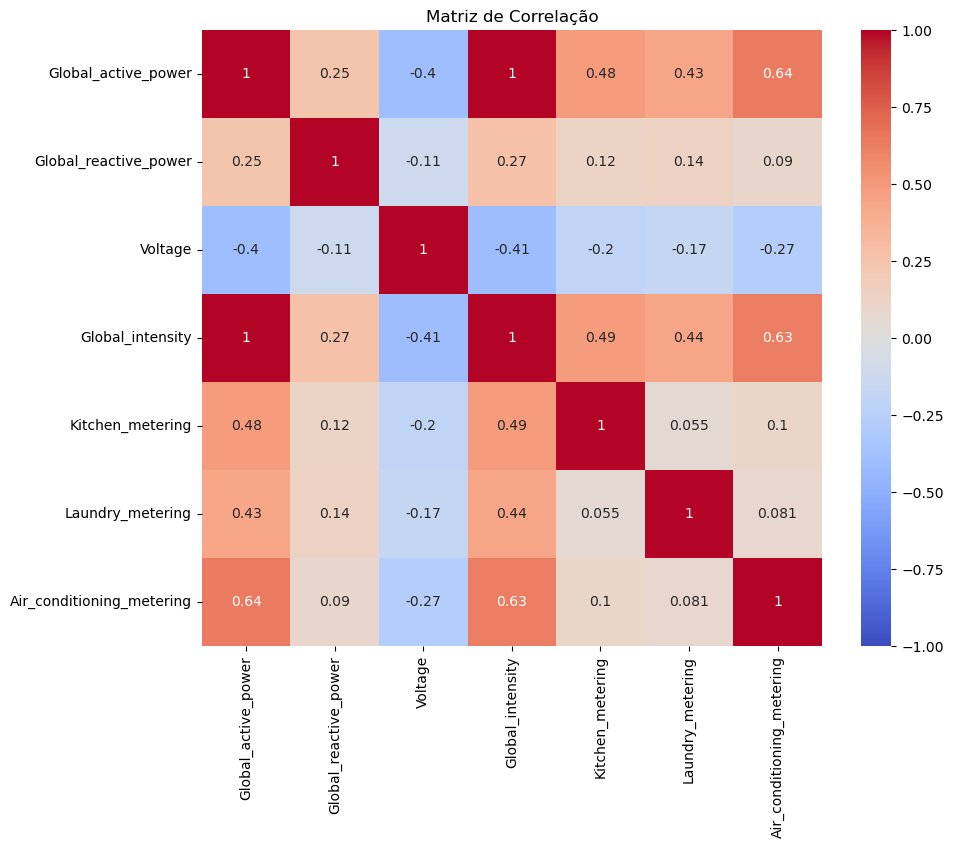

In [39]:
correlation_matrix = df[continuous].corr()

# Plotando a matriz de correlação usando seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação')
plt.show()

Podemos ver que a correlação entre "Global_active_power" e "Global_intensity" é 1, temos esse valor pois a potência (Power) é diretamente proporcional a corrente (Intensity), quando um sobe o outro sobe na mesma proporção. 

A variável "Voltage" tem uma correlação negativa moderada com "Global_active_power" (-0.4) e com "Global_intensity" (-0.41), isso indica que de mogo geral, quando a tensão da rede elétrica sobe um pouco, o consumo de potência e corrente tendem a diminuir ligeiramente. Muitos aparelhos são projetados para entregar uma potência cosntante, se a tensão sobe, eles precisam de menos corrente para fazer o mesmo trabalho.

Vemos que "Air_conditioning_metering" (0.64) tem a maior correlação entre os cômodos, isso mostra que é o que mais impacta no consumo geral da casa, em seguida temos "Kitchen_metering" (0.48) e "Laundry_metering" (0.43) que ambos tem um grande impacto também

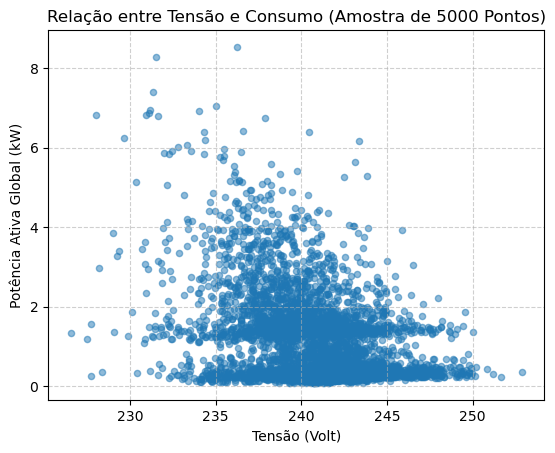

In [41]:
df_amostra = df.sample(n=5000, random_state=42)

df_amostra.plot.scatter(x='Voltage', y="Global_active_power", alpha=0.5)
plt.title('Relação entre Tensão e Consumo (Amostra de 5000 Pontos)')
plt.xlabel('Tensão (Volt)')
plt.ylabel('Potência Ativa Global (kW)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Podemos ver que a grande maioria dos pontos e principalmente os pontos de maior consumo estão concentrados na faixa de tensão entre aproximadamente 235 e 245 Volts, essa e a faixa de tensão mais comum fornecida pela rede elétrica para essa casa.

Nos extremos do gráfico o consumo de energia é consistentemente baixo, isso pode indicar duas coisas
Casualidade: Quando a tensão da rede está instável, os aparelhos de alta potência podem ter mecanismos de proteção que impedem de funcionar.

Frequência: Os momentos em que a tensão atinge esses extremos são muito raros e por acaso não coincidem com os momentos que os moradores estão usando muitos aparelhos

Se olharmos para a massa principal de pontos, ela parece se inclinar sutilmente para a esquerda, os picos mais altos de consumo (em torno de 8kW) acontecem com mais frequência quando a tensão está na faixa de 235-240V do que na faixa de 240-245V

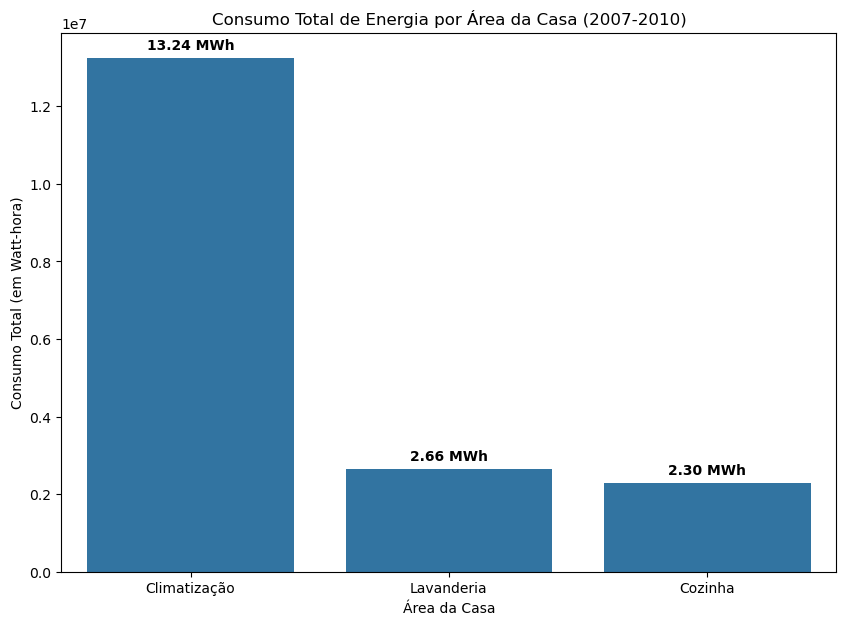

In [43]:
consumo_total_areas = {
    'Climatização': df['Air_conditioning_metering'].sum(),
    'Cozinha': df['Kitchen_metering'].sum(),
    'Lavanderia': df['Laundry_metering'].sum()
}

somas_series = pd.Series(consumo_total_areas)
somas_series = somas_series.sort_values(ascending=False)


plt.figure(figsize=(10, 7))
barplot = sns.barplot(x=somas_series.index, y=somas_series.values)
plt.title('Consumo Total de Energia por Área da Casa (2007-2010)')
plt.ylabel('Consumo Total (em Watt-hora)')
plt.xlabel('Área da Casa')

for p in barplot.patches:
    barplot.annotate(f'{p.get_height() / 1e6:.2f} MWh',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     xytext=(0, 9),
                     textcoords='offset points',
                     fontweight='bold')
plt.show()

Como podemos ver o circuito de Climatização é, de longe, o maior vilão do consumo de energia desta casa, é mais que o dobro da soma das outras duas áreas combinadas, já o consumo da Lavanderia e da Cozinha embora menores estão relativamente próximos

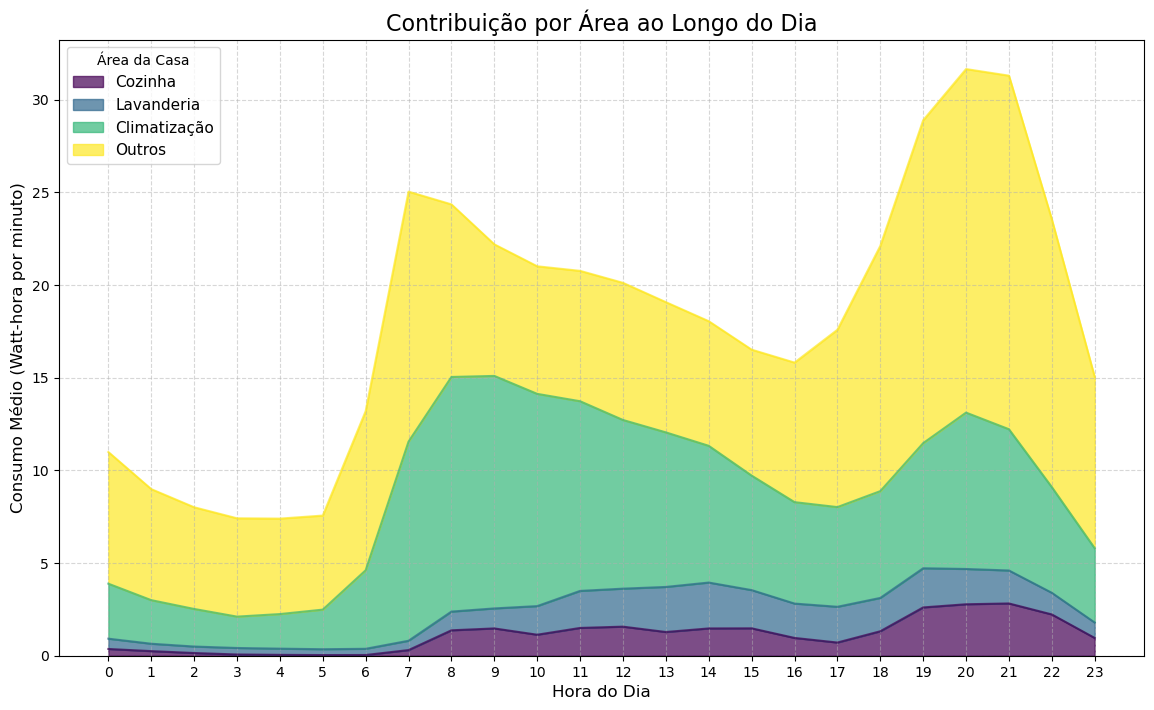

In [45]:
df_grafico = df.copy()

df_grafico["Potencia_Ativa_Wh"] = df_grafico["Global_active_power"] * 1000 / 60

sub_meterings = ['Kitchen_metering', 'Laundry_metering', 'Air_conditioning_metering']
df_grafico['Soma_Submedidores'] = df_grafico[sub_meterings].sum(axis=1)
df_grafico['Outros_Wh'] = (df_grafico['Potencia_Ativa_Wh'] - df_grafico['Soma_Submedidores']).clip(lower=0)

coluna_consumo = ['Kitchen_metering', 'Laundry_metering', 'Air_conditioning_metering', 'Outros_Wh']
consumo_horario_areas = df_grafico[coluna_consumo].groupby(df_grafico.index.hour).mean()
consumo_horario_areas.columns = ['Cozinha', 'Lavanderia', 'Climatização', 'Outros']

consumo_horario_areas.plot(
    kind='area',
    stacked=True,
    figsize=(14, 8),
    alpha=0.7,
    colormap='viridis'
)

plt.title("Contribuição por Área ao Longo do Dia", fontsize=16)
plt.xlabel("Hora do Dia", fontsize=12)
plt.ylabel("Consumo Médio (Watt-hora por minuto)", fontsize=12)
plt.xticks(range(0, 24))
plt.legend(title='Área da Casa', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

Aqui podemos ver que o uso da Cozinha e da Lavanderia é baixo durante o dia, a lavanderia com um mais uso na parte do dia e a noite, muito provavelmente o morador deixa a roupa lavando durante o dia e a noite secando pois o gasto de energia é maior a noite, a outra área da casa que mais gasta é a climatização, principalmente na parte da manhã

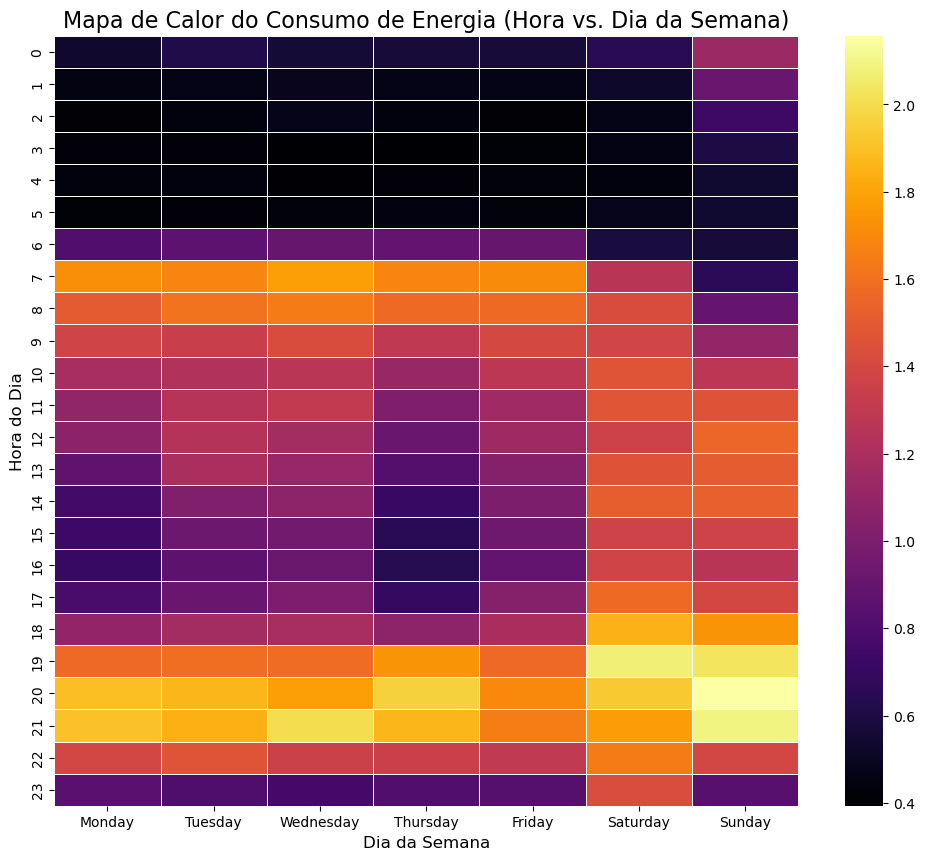

In [47]:
pivot_consumo = df.pivot_table(
    values='Global_active_power',
    index=df.index.hour,
    columns=df.index.day_name(),
    aggfunc='mean'
)

ordem_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_consumo = pivot_consumo[ordem_dias]

plt.figure(figsize=(12, 10))

sns.heatmap(
    pivot_consumo,
    cmap='inferno',
    annot=False,
    linewidths=.5
)

plt.title('Mapa de Calor do Consumo de Energia (Hora vs. Dia da Semana)', fontsize=16)
plt.xlabel('Dia da Semana', fontsize=12)
plt.ylabel('Hora do Dia', fontsize=12)
plt.show()

Podemos ver que temos o nosso consumo de energia principalmente a partir das 6h, com um pico as 7h e uma queda durante a tarde com um novo pico durante a noite, isso se repete durante os dias da semana de segunda a sexta, no final de semana o grande diferencial é por conta do uso durante a tarde, temos um volume maior do que durante semana pois os moradores estão em casa

## Modelagem

Iremos começar a nossa modelagem e iremos utilizar dois modelos para vermos qual melhor se encaixa nos nossos dados, o XGBoost e o RandomForest, também utilizaremos o cross-validation para ter os resultados o mais próximo possíveis da realidade

### XGBoost

In [52]:
df_modelo = df.copy()

# Features de Tempo
df_modelo['hora'] = df_modelo.index.hour
df_modelo['dia_da_semana'] = df_modelo.index.dayofweek # Segunda=0, Domingo=6
df_modelo['mes'] = df_modelo.index.month
df_modelo['dia_do_ano'] = df_modelo.index.dayofyear
df_modelo['eh_fim_de_semana'] = (df_modelo.index.weekday >= 5).astype(int)

# Features de Lag
df_modelo['lag_24h'] = df_modelo['Global_active_power'].shift(24) # Consumo no mesmo horário do dia anterior
df_modelo['lag_1w'] = df_modelo['Global_active_power'].shift(24 * 7) # Consumo na semana anterior

# Tendência Recente
df_modelo['media_movel_24h'] = df_modelo['Global_active_power'].rolling(window=24).mean().shift(1)

df_modelo.dropna(inplace=True)
df_modelo.drop('Dia_da_Semana', axis=1, inplace=True)

In [53]:
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2049112 entries, 2006-12-16 20:12:00 to 2010-11-26 21:02:00
Data columns (total 15 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Global_active_power        float64
 1   Global_reactive_power      float64
 2   Voltage                    float64
 3   Global_intensity           float64
 4   Kitchen_metering           float64
 5   Laundry_metering           float64
 6   Air_conditioning_metering  float64
 7   hora                       int32  
 8   dia_da_semana              int32  
 9   mes                        int32  
 10  dia_do_ano                 int32  
 11  eh_fim_de_semana           int32  
 12  lag_24h                    float64
 13  lag_1w                     float64
 14  media_movel_24h            float64
dtypes: float64(10), int32(5)
memory usage: 211.1 MB


Criamos um dataframe para o modelo e criamos variaveis novas para o modelo prever melhor, como hora, dia da semana, mes, dia do ano, se é final de semana

In [55]:
FEATURES = [col for col in df_modelo.columns if col not in ['Global_active_power', 'Global_intensity']]
TARGET = 'Global_active_power'

X, y = df_modelo[FEATURES], df_modelo[TARGET]
print(X.columns)

Index(['Global_reactive_power', 'Voltage', 'Kitchen_metering',
       'Laundry_metering', 'Air_conditioning_metering', 'hora',
       'dia_da_semana', 'mes', 'dia_do_ano', 'eh_fim_de_semana', 'lag_24h',
       'lag_1w', 'media_movel_24h'],
      dtype='object')


In [56]:
X_train_val = X.loc[:'2009-12-31']
y_train_val = y.loc[:'2009-12-31']

X_test_final = X.loc['2010-01-01':]
y_test_final = y.loc['2010-01-01':]

Em seguida separamos nossas features e nosso target, excluimos também das features a Global Intensity que tem uma correlação de 1 com a nossa variável target o que iria impactar em uma "cola" para o nosso modelo

In [58]:
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [500, 1000],
    'learning_rate': [0.05, 0.1]
}

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42)

tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    verbose=2, 
    n_jobs=-1
)

print("Iniciando o Grid Search...")
grid_search.fit(X_train_val, y_train_val)

print("\n--- Resultados do Grid Search ---")
print(f"Melhores Hiperparâmetros Encontrados: {grid_search.best_params_}")

best_mae = -grid_search.best_score_
print(f"Melhor MAE encontrado durante a validação cruzada: {best_mae:.4f}")

Iniciando o Grid Search...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

--- Resultados do Grid Search ---
Melhores Hiperparâmetros Encontrados: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}
Melhor MAE encontrado durante a validação cruzada: 0.1912


Fazemos um GridSearch pequeno e criamos nosso modelo do XGBoost, ele achou os parâmetros acima como os melhores e um MAE bem bom

In [60]:
# Fazer previsões no conjunto de teste
predictions_xgb = grid_search.predict(X_test_final)

# Calcular o erro
mae = mean_absolute_error(y_test_final, predictions_xgb)
r2_2 = r2_score(y_test_final, predictions_xgb)

print(f"\nO Erro Médio Absoluto (MAE) do XGBoost foi: {mae:.4f}")
print(f"Isso significa que, em média, as previsões do modelo erram em {mae:.4f} kW.")
print(f'R² da Regressão do XGBoost: {r2_2:.4f}')


O Erro Médio Absoluto (MAE) do XGBoost foi: 0.1578
Isso significa que, em média, as previsões do modelo erram em 0.1578 kW.
R² da Regressão do XGBoost: 0.9179


Aqui vemos que nosso modelo realmente está bem acertivo com um R2 de 0.91, um MAE de 0.15 isso significa que ele em média erra as pevisões em apenas 0.15Kw o que é algo muitissimo perto da realidade

### Random Forest

In [63]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_leaf': [5, 10]
}

rf_reg = RandomForestRegressor(n_jobs=-1, random_state=42)
tscv = TimeSeriesSplit(n_splits=5)

grid_search_rf = GridSearchCV(
    estimator=rf_reg,
    param_grid=param_grid_rf,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    verbose=2, 
    n_jobs=-1
)

print("Iniciando o Grid Search...")
grid_search_rf.fit(X_train_val, y_train_val)

print("\n--- Resultados do Grid Search ---")
print(f"Melhores Hiperparâmetros Encontrados: {grid_search_rf.best_params_}")

best_mae = -grid_search_rf.best_score_
print(f"Melhor MAE encontrado durante a validação cruzada: {best_mae:.4f}")

Iniciando o Grid Search...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

--- Resultados do Grid Search ---
Melhores Hiperparâmetros Encontrados: {'max_depth': 20, 'min_samples_leaf': 10, 'n_estimators': 200}
Melhor MAE encontrado durante a validação cruzada: 0.1732


Fazemos o mesmo processo com o RandomForest fazendo um GridSearch e achamos um MAE um pouco maior que o XGBoost

In [65]:
predictions_rf = grid_search_rf.predict(X_test_final)

mae_rf = mean_absolute_error(y_test_final, predictions_rf)
r2_2_rf = r2_score(y_test_final, predictions_rf)

print(f"\nO Erro Médio Absoluto (MAE) do Random Forest foi: {mae_rf:.4f}")
print(f"Isso significa que, em média, as previsões do modelo erram em {mae_rf:.4f} kW.")
print(f'R² da Regressão do Random Forest: {r2_2_rf:.4f}')


O Erro Médio Absoluto (MAE) do Random Forest foi: 0.1395
Isso significa que, em média, as previsões do modelo erram em 0.1395 kW.
R² da Regressão do Random Forest: 0.9227


Nosso r2 do RandomForest se saiu melhor que o XGBoost, mas vamos ver em gráficos como ficou essas previsões

---

In [67]:
resultados_finais = y_test_final.to_frame()
resultados_finais['Previsao_RandomForest'] = predictions_rf
resultados_finais['Previsao_XGBoost'] = predictions_xgb

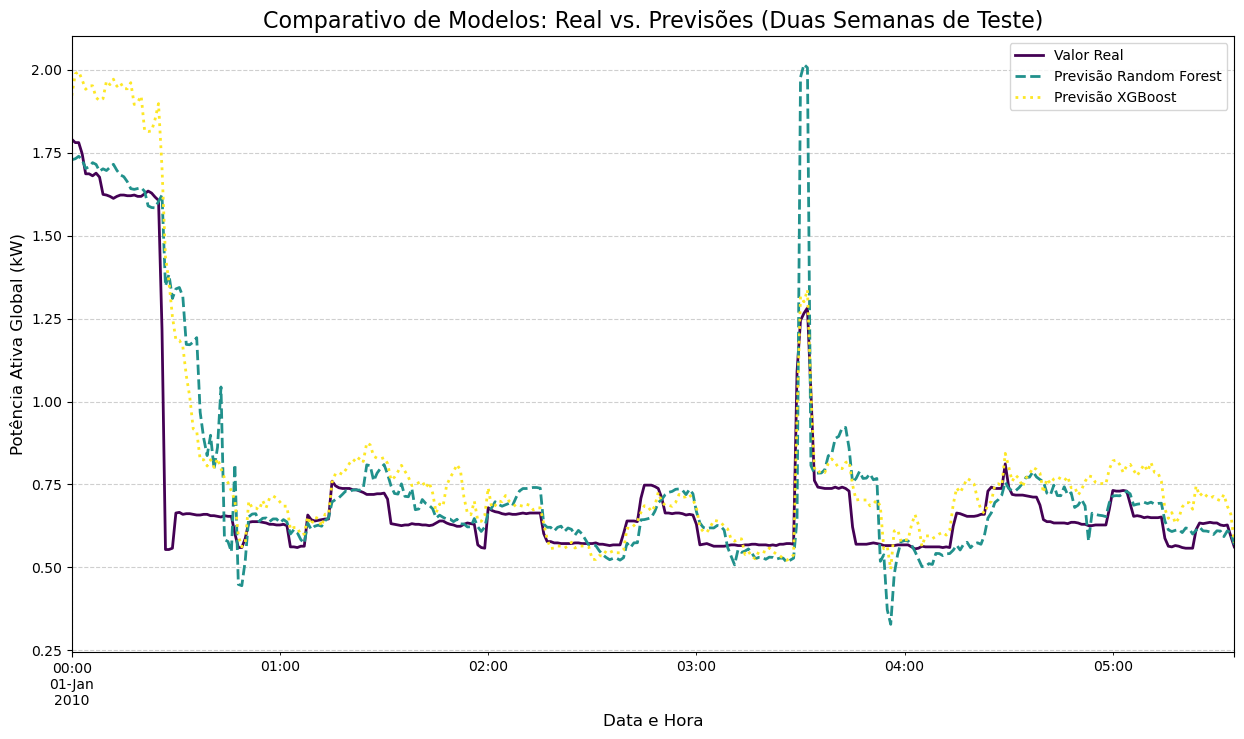

In [68]:
# (24 horas * 14 dias = 336 pontos)
dados_grafico = resultados_finais.head(336)

dados_grafico.plot(
    figsize=(15, 8),
    style=['-', '--', ':'], # Linha sólida para o real, tracejada para RF, pontilhada para XGB
    linewidth=2,
    colormap='viridis'
)

plt.title('Comparativo de Modelos: Real vs. Previsões (Duas Semanas de Teste)', fontsize=16)
plt.ylabel('Potência Ativa Global (kW)', fontsize=12)
plt.xlabel('Data e Hora', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(['Valor Real', 'Previsão Random Forest', 'Previsão XGBoost'])
plt.show()

Podemos ver que a previsão do XGBoost (linha amarela) é um pouco mais suave enquanto a do Random Forest (Linha Azul) é mais volátil e reativa, visualizando apenas o gráfico vemos que o xgboost manteve mais próximo a linha de valor real do que o RandomForest

In [70]:
mae_rf = mean_absolute_error(y_test_final, predictions_rf)
r2_rf = r2_score(y_test_final, predictions_rf)

mae_xgb = mean_absolute_error(y_test_final, predictions_xgb)
r2_xgb = r2_score(y_test_final, predictions_xgb)

In [71]:
dados_metricas = {
    'Modelo': ['Random Forest', 'XGBoost'],
    'MAE': [mae_rf, mae_xgb],
    'R²': [r2_rf, r2_xgb]
}
df_metricas = pd.DataFrame(dados_metricas)

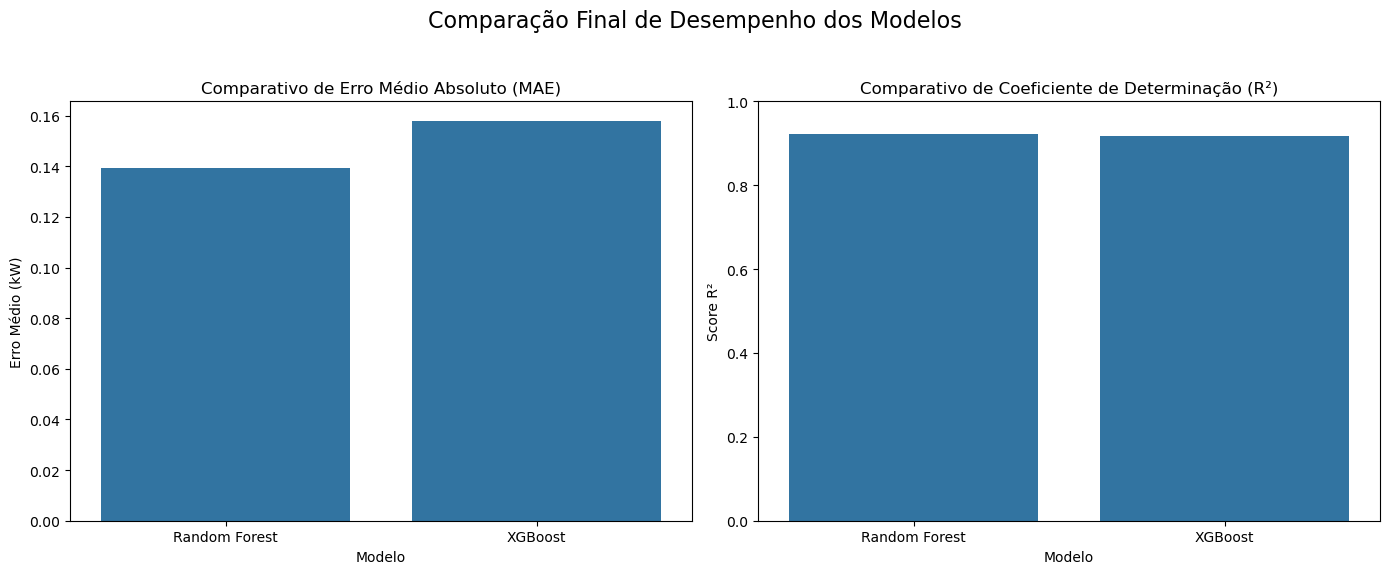

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) # Cria 1 linha, 2 colunas de gráficos

# Gráfico do MAE
sns.barplot(x='Modelo', y='MAE', data=df_metricas, ax=axes[0])
axes[0].set_title('Comparativo de Erro Médio Absoluto (MAE)')
axes[0].set_ylabel('Erro Médio (kW)')

# Gráfico do R²
sns.barplot(x='Modelo', y='R²', data=df_metricas, ax=axes[1])
axes[1].set_title('Comparativo de Coeficiente de Determinação (R²)')
axes[1].set_ylabel('Score R²')
axes[1].set_ylim(0, 1) # Define o limite do eixo y de 0 a 1 para o R²

plt.suptitle('Comparação Final de Desempenho dos Modelos', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta o layout para o supertítulo
plt.show()

Aqui podemos ver que o MAE do RandomForest foi em torno de 0.14kW enquanto do XGBoost foi de 0.16kW, isso significa que se considerarmos a média de todos os erros ao longo de todo o periodo de testes, as previsões do Random Forest estiveram, no geral, um pouco mais próximas do valores reais do que do XGBoost

Já no gráfico a direita mostra um empate técnico entre RandomForest e XGBoost os dois por volta de 0.92.

Vimos que o Random Forest era muito agressivo errando feio nos picos (superestimando muito o consumo). No entando, é provavél que ele tenha sido extremamente preciso nos períodos de baixo consumo, que correspondem a maior parte do tempo, seus muitos acertos perfetios nos momentos calmos compensaram seus grandes erros nos picos.

Já o XGBoost foi mais conservador, ele pode ter um erro pequeno e consistente a longo de todo o tempo, ele não errou geio nos picos mas talvez não tenha acertado perfeitamente os períodos calmos como o Random Forest.

In [74]:
best_rf_model = grid_search_rf.best_estimator_
best_xgb_model = grid_search.best_estimator_

In [75]:
# Para o Random Forest
feature_importance_rf = pd.DataFrame({
    'Feature': X_train_val.columns, # Usa as colunas do seu df de treino
    'Importance': best_rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)

# Para o XGBoost
feature_importance_xgb = pd.DataFrame({
    'Feature': X_train_val.columns,
    'Importance': best_xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)


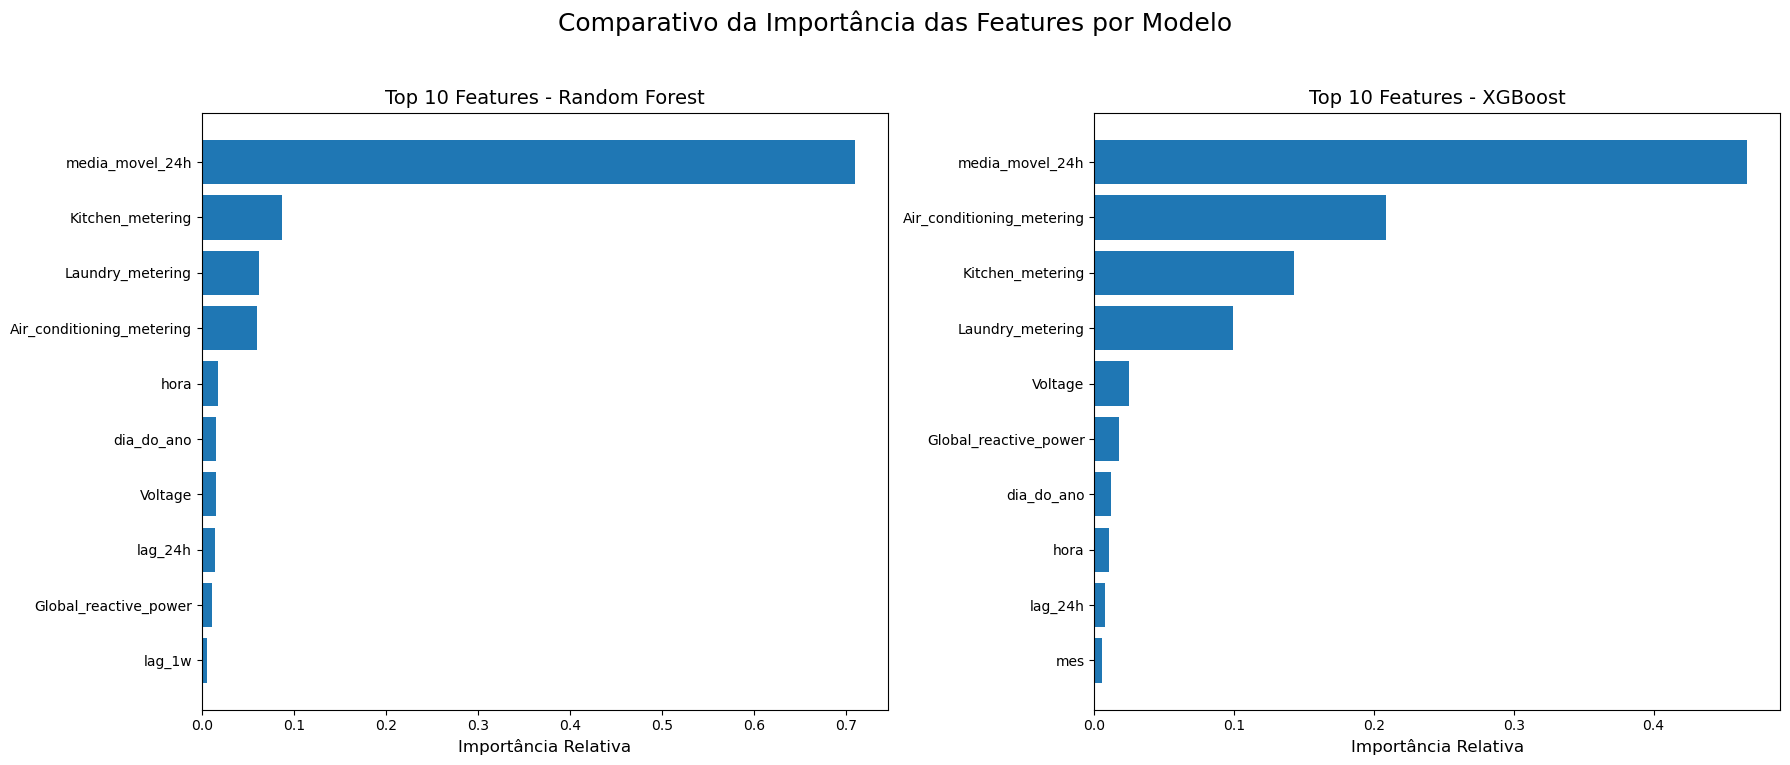

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Gráfico para o Random Forest (à esquerda)
axes[0].barh(feature_importance_rf['Feature'], feature_importance_rf['Importance'])
axes[0].invert_yaxis() # A feature mais importante fica no topo
axes[0].set_title('Top 10 Features - Random Forest', fontsize=14)
axes[0].set_xlabel('Importância Relativa', fontsize=12)


# Gráfico para o XGBoost (à direita)
axes[1].barh(feature_importance_xgb['Feature'], feature_importance_xgb['Importance'])
axes[1].invert_yaxis()
axes[1].set_title('Top 10 Features - XGBoost', fontsize=14)
axes[1].set_xlabel('Importância Relativa', fontsize=12)


# --- Aprimoramentos Finais ---
# Adiciona um título geral para a figura
plt.suptitle('Comparativo da Importância das Features por Modelo', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta o layout para caber o supertítulo
plt.show()

Ambos os modelos concordam, de forma unanime que a media_movel_24h é a feature mais importante de todas, mas após essa variável percebemos que o random forest deu uma importância gigante para apenas uma variável enquanto no XGBoost, ele foi mais conservador utilizando também outras variáveis para a predição

## Conclusão

Nesse projeto, meu objetivo foi desvendar os segredos escondidos no "diário elétrico" de uma casa, transformando milhões de registros de consumo em uma história sobre a rotina de uma família. O que descobrimos foi longe de ser aleatório, o gasto de energia é um reflexo fiel da vida. Ele acorda com a família por volta das 7h da manhã, sai para o trabalho e tem seu pico de gasto a noite quando todos estão em casa. Identificamos o grande vião de consumo que é sistema de climatização e vimos como os fins de semana têm uma energia completamente diferente dos dias de semana.

Colocamos dois dos modelos mais inteligentes, Random Forest e XGBoost, em uma competição para ver qual deles aprenderia melhor os costumes da casa. Após um treinamento e uma otimização, usando a técnica de Cross Validation e o resultado foi impressionante. Ambos os modelos conseguiram prever o consumo com uma precisão incrivel de mais de 91%. No entanto, o XGBoost se consagrou como o campeão. Ele foi mais conservador na previsão do que o Random Forest não tendo sido tão impactado pelos picos e vales, também utilizou melhor as variáveis ampliando sua contribuição, coisa que o RandomForest focou muito em apenas uma variável (por isso foi mais suscetivo aos picos e vales), mesmo tendo um MAE girealmente maior que o RandomForest é um modelo que se adaptou melhor aos dados e tem uma precisão impressionante